# Part 1 

# Shopify Data challenge
By: Vy Khanh Pham 

## Problem

On Shopify, we have exactly 100 sneaker shops, and each of these shops sells only one model of shoe. We want to do some analysis of the average order value (AOV). When we look at orders data over a 30 day window, we naively calculate an AOV of $3145.13. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis. 

1. Think about what could be going wrong with our calculation. Think about a better way to evaluate this data. 
2. What metric would you report for this dataset?
3. What is its value?

## Short Answers: 

**Please read the 'Work and Further Explanation' for a more detailed explanations of each approach!**

The AOV was originally calculated by averaging the `order_amount` which resulted in a big number like $3145. This is because **mean is sensitive to outliers** and it is not a robust measure of central tendency. So... what do we do?

Here are 4 solutions/approaches: 
1. I would recommend to use the **median**, which is a more robust measure of central tendency as it is not sensitive to outliers. 

2. **Log transformation** can also be used to transform skewed data to approximately conform to normality. We can calculate the AOV using $e^{\frac{1}{n}\sum_{i = 1}^{n}log(x_i)}$ or $e^{mean(log(X))}$. Although the `log order amount` is still right-skewed in our scenerio, the outliers are weighted a lot less and our standard deviation is low ($0.84$). 

3. Another approach is to find the mean of `order_amount` after **removing outliers**, although this might not be the best approach for several reasons. (Read the section below for more explanations!)

4. Randomly sample (with replacement) from our dataset for a large amount of time and calculate the mean for each sample.Then, find the **mean of sample means** to get the AOV. This idea comes from the **central limit theorem**. *Note: This is after removing outliers,*

Values based on approaches: 
1. Median approach: $\$284$ 

2. Log transformation approach (Mean): $\$285.02$ 

3. Removing outliers approach (Mean):  $\$293.72$ 

4. Sampling Approach (Outliers Removed): $\$293.42$

These different approaches yield very similar results. 
**It appears that the AOV falls between $280 - 295**. 

## Work and Further Explanation

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings('ignore')
shoe_store_data_dir = "ShopifyShoeDataset.csv"

In [4]:
shoe_store_df = pd.read_csv(shoe_store_data_dir)

### Part A 

**Question:** Think about what could be going wrong with our calculation. Think about a better way to evaluate this data. 

**Explanation**: From `describe()` we can see that the AOV or mean is $\$3,145.13$.The mean, standard deviation, and maximum values are huge relative to the median. Upon plotting the box plot (used log transformation for better visualization) we can verify that the outliers are influencing our results. How? We are using the **mean** which is highly sensitive to outliers. 

Looking closer at the data, we see that the $\$704,000$ refers to a large order of 2000 coming from the same user and shop with an average value of  $\$352$. This appears to be a buyer that's perhaps purchasing wholesale for their own business, which is not the typically behavior of an average buyer. 

**Work**: 

In [5]:
shoe_store_df.order_amount.describe()

count      5000.000000
mean       3145.128000
std       41282.539349
min          90.000000
25%         163.000000
50%         284.000000
75%         390.000000
max      704000.000000
Name: order_amount, dtype: float64

Since are outliers are huge, I decided to do a log transformation to better present the distribution of `order_amount`.

In [6]:
df_log = np.log(shoe_store_df[['order_amount']].rename(columns={'order_amount' : 'Log order Amount'}))

Text(0.5, 1.0, 'Distribution of Order Amount (Log)')

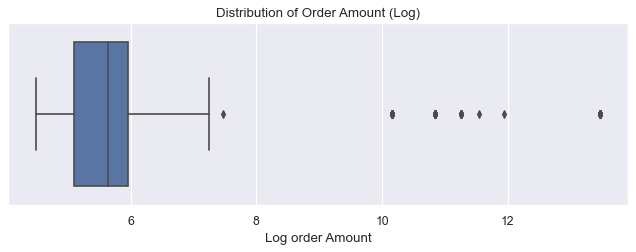

In [7]:
figure(figsize=(10, 3), dpi=80)
sns.set_theme()
sns.boxplot(x=df_log['Log order Amount']).set_title("Distribution of Order Amount (Log)")

Here is also another visulation that helps us understand the distribution. Below, I ploted total_items vs order_amount including and then excluding the extremely large order of 2,000 shoes. Interesting, we see some really high order amount even for relatively low number of items per order.  

Text(0.5, 1.0, 'Total Items vs Order Amount (Exclude total items of 2000)')

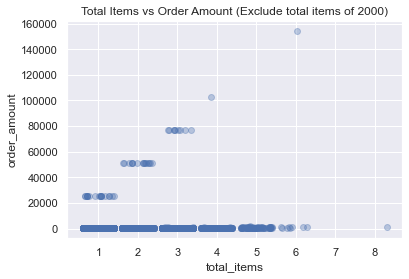

In [23]:
(sns.regplot(data = shoe_store_df[shoe_store_df['total_items'] != 2000], 
             x = 'total_items', 
             y = 'order_amount', 
             fit_reg = False,
             x_jitter = 0.4 , 
             scatter_kws = {'alpha' : 1/3}
            ).set_title("Total Items vs Order Amount (Exclude total items of 2000)")
)

Let's look at our outliers. It appears to be bulk orders of 2000 shoes. 

In [9]:
shoe_store_df.sort_values('order_amount', ascending=False).head(4)

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
2153,2154,42,607,704000,2000,credit_card,2017-03-12 4:00:00
3332,3333,42,607,704000,2000,credit_card,2017-03-24 4:00:00
520,521,42,607,704000,2000,credit_card,2017-03-02 4:00:00
1602,1603,42,607,704000,2000,credit_card,2017-03-17 4:00:00


In [10]:
704000 / 2000 # Average value per shoe 

352.0

### Part B and C:  Approach and Values

### Approach 1: Finding the median

The mean is not a robust statistics because it is highly sensitive to outliers and non-normal distributions. This mean that extremely large values can "drag" the mean up and extremely low values can "drag" the mean down. 
The median on the other hand is a robust statistic as it is not sensitive to outliers. 

In [11]:
np.median(shoe_store_df['order_amount'])

284.0

### Approach 2: Log Transformation

There are many other transformations out there but log transformation is often used to transform skewed data to approximately conform to normality. With this in mind, I will find the average log order amount and then transform it back to the original units using exponential. 

**The AOV is $\$285.02$.** 

In [12]:
log_order_amount = np.log(shoe_store_df['order_amount'])
log_avg = np.mean(log_order_amount) # Log transformation and then average
np.exp(log_avg) #Transform back to normal!

285.0204747254945

Looking at the distribution of the log order_amount, however, we can see that the histogram is still not normally distributed. However, our standard deviation is significantly lower and the outliers aren't weighted as heavily as before. So although the outliers will still drive our result up higher, it will not be as significant as before.

[Text(0.5, 0, 'Log order Amount')]

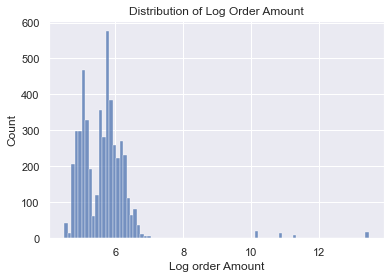

In [22]:
ax = sns.histplot(data=log_order_amount)
ax.set_title('Distribution of Log Order Amount')
ax.set(xlabel = 'Log order Amount')

In [18]:
order_amount = shoe_store_df['order_amount']

print("standard deviation")
print("before: ", round(np.std(order_amount), 2))
print("after: ", round(np.std(log_order_amount), 2))

standard deviation
before:  41278.41
after:  0.84


### Approach 3: Removing Outliers 

**Explanation**: 

Although this is a plausible approach to dealing with outliers in calculating AOV, there are many isssues with this. 
1. If the outlier data are legitamite samples, they can be informative and can provide other insights. 
2. With a small dataset, removing outliers can significantly change the outcome. Deleting them could bias our result significantly. 
3. High computational cost when we're dealing with a larger dataset or may not be feasible when dealing with real-time data. 

To exclude the outliers, I calculated Quartile 1 (25th percentile) and Quartile 3 (75th percentile). Then I calculated the IQR (Interquartile range). I calculated the lower and upper fences of $[-177.5, 730.5]$. This means that any data that lies outside of this range is considered to be an outlier. 

After removing the outliers, we received **the AOV of $\$293.71$** with 141 outliers dropped. using `describe()` for `order_amount` with no outliers, we now have a standard deviation of around **$\$144.45$** , much lower than before!

**Work**:

In [13]:
order_amount = shoe_store_df['order_amount']

In [14]:
Q1 = order_amount.quantile(0.25)
Q3 = order_amount.quantile(0.75)
IQR = Q3 - Q1
Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

(-177.5, 730.5)

In [15]:
order_amount_without_outliers = order_amount[order_amount.between(Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)]
np.mean(order_amount_without_outliers), np.std(order_amount_without_outliers)

(293.7153735336489, 144.43852968691695)

From this approach, we ended up dropping 141 data points. 

In [16]:
len(order_amount) - len(order_amount_without_outliers)

141

### Approach 4: Sampling 

**Explanation**: 

Randomly sample (with replacement) from our original dataset for a large amount of times and calculate the mean for each sample. Then, calculate the **mean of the sample means** to find the AOV. 

This idea comes from the **Central Limit theorem**, which states that if you take sufficiently large random samples from the population with replacement, then the distribution of the sample means will be approximately normally distributed. Furthermore, **the mean of the sample means will be approximately equal to the population mean**. We don't have the entire population right now, but we do have a 30 day sample that we can resample to create many simulated samples (this is called bootstrapping). 

It looks like the AOV from removing outliers and calculating the mean of sample means is $\$293.42$. The standard deviation of our sample means is $\$10.01$. 

In [21]:
def AOV_Bootstrap_Sample_Means(series, num_samples, sample_size): 
    """
        Takes in a series, bootstraps it num_samples of time with sample_size size for each sample. 
        Then, returns the mean of sample means and standard deviation. 
    """
    np.random.seed(2004) # same seed for replication purposes only! (This is also a special year :D)
    sample_means = []
    for _ in range(num_samples): 
        sample_data = series.sample(n = sample_size, replace = True)
        sample_means.append(np.mean(sample_data))
    return sample_means

NUM_SAMPLES = 1000
SAMPLE_SIZE = 200

samples = AOV_Bootstrap_Sample_Means(order_amount_without_outliers, NUM_SAMPLES, SAMPLE_SIZE)
np.mean(samples), np.std(samples)

(293.42303000000004, 10.006868327259033)

# Part 2

### **Question 1** : How many orders were shipped by Speedy Express in total?

**Solution** : 54

`
    SELECT COUNT(DISTINCT OrderID) AS speedy_shipped
    FROM Orders
    JOIN Shippers 
    ON Orders.ShipperID = Shippers.ShipperID
    WHERE Shippers.ShipperName = "Speedy Express";
`

**Explanation**:
To find how many orders were shipped by Speedy Express, I: 
1. Joined the Orders and Shippers table on ShipperID 
2. Use COUNT and DISTINCT to find the unique orders that have been shipped
3. Then I used WHERE to find "Speedy Express" 

### **Question 2** : What is the last name of the employee with the most orders?

**Solution** : Peacock

` 
    SELECT a.LastName 
    FROM Employees as a, 
        (SELECT EmployeeID, 
            COUNT(*) as TotalOrder
            FROM Orders GROUP BY EmployeeID
            ORDER BY TotalOrder DESC LIMIT 1) as b 
    WHERE a.EmployeeID = b.EmployeeID;
`

**Explanation**: 
Let's break it down! 

In this part, I took the table TotalOrder and **grouped by** Employee ID. When grouping I used COUNT(\*) to count the total number of orders each employee made (Denoted as TotalOrder). Then, I **ordered** TotalOrder in descending order and used LIMIT 1 to isolate the employee with the highest amount of order. 

Let's denote this TABLE_A for the next part. 

`
    SELECT EmployeeID, 
    COUNT(*) as TotalOrder
    FROM Orders GROUP BY EmployeeID
    ORDER BY TotalOrder DESC LIMIT 1;
`
    

Then finally, I found the Employee's last name whose ID equals that ID of the only remaining Employee in TABLE_A.   

`
    SELECT a.LastName 
    FROM Employees as a, TABLE_A as b 
    WHERE a.EmployeeID = b.EmployeeID;
`

### **Question 3**: What product was ordered the most by customers in Germany?

**Solution**: Boston Crab Meat
 
`
        SELECT p.ProductName, SUM(od.Quantity) AS TotalUnitsSold
        FROM orderDetails as od 
        JOIN Orders as o 
            ON od.orderId=o.orderId
        JOIN Products p 
            ON od.productId = p.productId
        JOIN Customers c 
            ON o.customerId=c.customerId
        WHERE c.country='Germany'
        GROUP BY p.productId
        ORDER BY TotalUnitsSold DESC
        LIMIT 1; 
`

**Explanation**: 
In this question, I am interpreting that "ordered the most" means the products with the highest units sold. If the question referred to product that appears in the most orders, then I would simply change SUM(od.Quantity) to COUNT(od.Quantity). 

First, I joined orderdetails, orders, products, and customers. Then, I know that we need the customers to be from Germany, so I used WHERE c.country = 'Germany' to filter from there. Then, we need to figure out which product sold the most units so I used GROUP BY to group by the productID and SUM to sum up the amount of units sold while grouping. Then finally, I ordered SUM(od.Quantity) in Descending order and LIMIT 1 to isolate the product with the highest amount of units sold. 


